Datos cargados exitosamente.
Vectores promedio de Word2Vec:
[[ 0.00017117 -0.00023709  0.00101066 ...  0.00053264 -0.00170498
  -0.00023669]
 [-0.00340243  0.00443886 -0.00316347 ... -0.00335237  0.00099146
   0.00302364]
 [-0.0067749   0.0021796  -0.00262231 ... -0.00672233 -0.00997708
   0.00724622]
 ...
 [-0.00203047  0.00084168  0.00073573 ... -0.00206656 -0.00529526
  -0.00232061]
 [ 0.00070065 -0.00098148  0.00109488 ... -0.00133838  0.00067744
  -0.00143426]
 [-0.00234498 -0.00299736 -0.00030339 ... -0.00126365  0.00147225
   0.00182848]]


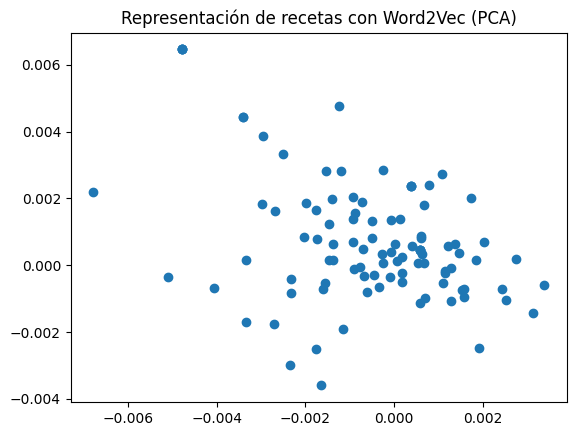

In [ ]:
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Inicializar spaCy
nlp = spacy.load("en_core_web_sm")


# Cargar el modelo BERT y el tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Asegurarse de que el modelo esté en modo de evaluación
model.eval()

# Ruta al archivo JSON (ajusta el path según donde esté ubicado el archivo)
path_file = "full_format_recipes.json"

# Cargar el archivo JSON como un DataFrame de Pandas
def load_recipes(file_path):
    try:
        with open(file_path, "r") as file:
            recipes_df = pd.read_json(file)
            recipes_df.dropna(inplace=True)
            print("Datos cargados exitosamente.")
            return recipes_df
    except ValueError as e:
        print(f"Error al leer el archivo JSON: {e}")
        return None

def preprocess_text_spacy(text):
    """
    Preprocesa el texto usando SpaCy:
    - Elimina caracteres no alfabéticos
    - Realiza tokenización y lematización
    """
    # Eliminar caracteres no alfabéticos
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Procesar el texto con SpaCy
    doc = nlp(text)

    # Tokenización y Lematización con SpaCy
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    text_lemma = ' '.join(tokens)

    # Convertimos el texto en una lista de tokens
    words = re.findall(r'\S+', text_lemma)

    # Devolver el texto procesado como lista de palabras
    return words

def compute_tfidf(docs):
    """
    Calcula la representación TF-IDF de los documentos.
    :param docs: Lista de documentos como texto
    :return: Matriz TF-IDF y el vectorizador
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)
    return tfidf_matrix, vectorizer

def compute_word2vec(docs):
    """
    Calcula la representación vectorial de documentos usando Word2Vec.
    :param docs: Lista de documentos como texto
    :return: Lista de vectores promediados para cada documento
    """
    # Tokenización de documentos
    tokenized_docs = [doc.split() for doc in docs]

    # Entrenamiento de Word2Vec
    model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)

    # Calcular promedio de embeddings para cada documento
    doc_vectors = []
    for tokens in tokenized_docs:
        word_vectors = [model.wv[word] for word in tokens if word in model.wv]
        if word_vectors:
            doc_vectors.append(np.mean(word_vectors, axis=0))
        else:
            doc_vectors.append(np.zeros(model.vector_size))

    return np.array(doc_vectors), model
def compute_bert_embeddings(docs):
    """
    Calcula los embeddings de BERT para cada documento.
    :param docs: Lista de documentos como texto
    :return: Lista de embeddings de documentos
    """
    embeddings = []

    for doc in docs:
        # Tokenizar el documento
        inputs = tokenizer(doc, return_tensors="pt", truncation=True, padding=True, max_length=512)


        # Pasar los tokens por BERT
        with torch.no_grad():  # No necesitamos gradientes para la inferencia
            outputs = model(**inputs)

        # Extraer los embeddings de la ´ultima capa oculta
        last_hidden_states = outputs.last_hidden_state

        # Tomamos la representación del token [CLS] (primer token)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()

        embeddings.append(cls_embedding)

    return np.array(embeddings)

# Cargar recetas
recipes_df = load_recipes(path_file)

# Tomar una muestra de las primeras 20 filas para prueba
recipes_df = recipes_df.iloc[0:100, :]

# Obtener la columna 'desc' (descripción de las recetas)
text_to_process = recipes_df.loc[:, "desc"]
ratings = recipes_df.loc[:, "rating"]

# Aplicar el preprocesamiento de texto a cada descripción
processed_words = text_to_process.apply(preprocess_text_spacy)

# Convertir la lista de palabras procesadas a un formato adecuado para TF-IDF y Word2Vec (como lista de strings)
processed_docs = [' '.join(words) for words in processed_words]

# 1. Aplicar TF-IDF
tfidf_matrix, vectorizer = compute_tfidf(processed_docs)

terms = vectorizer.get_feature_names_out()
matrix=tfidf_matrix.toarray()


"""
print("Terminos")
print(terms)
print("Matriz TF-IDF:")
for i, doc in enumerate(matrix):
    print(i)
    print(f"recipe {i+1}: {doc}")
"""

# 2. Aplicar Word2Vec
word2vec_vectors, word2vec_model = compute_word2vec(processed_docs)
print("Vectores promedio de Word2Vec:")
print(word2vec_vectors)

plt.figure(2)
# Plotear los vectores
plt.scatter(word2vec_vectors[:, 0], word2vec_vectors[:, 1])
plt.title("Representación de recetas con Word2Vec (PCA)")
plt.show()

# 3. Aplicar BERT
# Convertir las descripciones a una lista de documentos (sin preprocesar)
processed_docs = text_to_process.tolist()

# Obtener los embeddings de BERT para las descripciones
bert_embeddings = compute_bert_embeddings(processed_docs)

"""
# Mostrar los embeddings de BERT para los primeros 3 documentos
print("Embeddings de BERT:")
print(bert_embeddings[:3])  # Muestra los primeros 3 embeddings
"""

